## Doesn't work with FV3

In [1]:
import logging
import pdb
from pathlib import Path

import cartopy
import cmaps
import holoviews as hv
import matplotlib.colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import uxarray
import xarray
from tqdm import tqdm

try:  # Avoid ValueError when assigning cmap again
    cmap = cmaps.WhiteBlueGreenYellowRed
except ValueError:
    pass
import warnings

import geoviews.feature as gf
from hwt2024 import helicityThresholds, Model
from util import xtime

In [2]:
uxarray.__version__

'2024.8.3.dev21+g70ba961f.d20240909'

In [3]:
v = "updraft_helicity_max"
lon_bounds = (-95, -86)
lat_bounds = (36, 45)

features = gf.coastline(projection=cartopy.crs.PlateCarree(), scale="50m") * gf.states(
    projection=cartopy.crs.PlateCarree(), scale="50m"
)

In [4]:
%%time
grid_path = "/glade/campaign/mmm/parc/schwartz/MPAS/15-3km_mesh/mpas_init/static.nc"

# Multiple thresholds for updraft helicity
lead_time_days = range(2)
forecast_hours = range(13, 37, 6)
valid_date = pd.to_datetime("20240521")
oneday = pd.to_timedelta(1, unit="day")

model = Model("fv3", lead_time_days=8.5, nmem=10, v="SR_HELICITY_3KM")
model = Model("mpas", lead_time_days=5, nmem=5, v="updraft_helicity_max03")
assert model.name != "fv3", (
    "can't read fv3 cubed sphere nest yet.\n"
    "TODO:\n"
    "sfc and atmos variables split between two files "
    "atmos_sos*.nest02_%Y_%m_%d_%H.tile7.nc\n"
    "time dimension called time\n"
    "grid_xt = T-cell longitude\n"
    "grid_yt = T-cell latitude\n"
)

# Create list of input files
# This is a nested list comprehension, looping through
# forecast_hours (iterable of forecast hours)
#    lead_time_days (iterable of lead times in days)
#        members (1 through model.nmem)
fmt = "diag.%Y-%m-%d_%H.%M.%S.nc"
ifiles = [
    Path(f"/glade/campaign/mmm/parc/schwartz/HWT2024/{model}")
    / (valid_date - lead_time_day * oneday).strftime("%Y%m%d%H")
    / "post"
    / f"mem_{mem}"
    / (valid_date+pd.to_timedelta(fhr,unit="hour")).strftime(fmt)
    for mem in range(1, model.nmem + 1)
    for lead_time_day in lead_time_days
    for fhr in forecast_hours
]
print(f"open {len(ifiles)} files")

print(ifiles[0:10])
ds0 = xarray.open_mfdataset(
    ifiles,
    preprocess=xtime,
    combine_attrs="drop_conflicts",
)

uxds = uxarray.open_mfdataset(
    grid_path,
    ifiles,
    preprocess=xtime,
)
uxds

open 40 files
[PosixPath('/glade/campaign/mmm/parc/schwartz/HWT2024/mpas/2024052100/post/mem_1/diag.2024-05-21_13.00.00.nc'), PosixPath('/glade/campaign/mmm/parc/schwartz/HWT2024/mpas/2024052100/post/mem_1/diag.2024-05-21_19.00.00.nc'), PosixPath('/glade/campaign/mmm/parc/schwartz/HWT2024/mpas/2024052100/post/mem_1/diag.2024-05-22_01.00.00.nc'), PosixPath('/glade/campaign/mmm/parc/schwartz/HWT2024/mpas/2024052100/post/mem_1/diag.2024-05-22_07.00.00.nc'), PosixPath('/glade/campaign/mmm/parc/schwartz/HWT2024/mpas/2024052000/post/mem_1/diag.2024-05-21_13.00.00.nc'), PosixPath('/glade/campaign/mmm/parc/schwartz/HWT2024/mpas/2024052000/post/mem_1/diag.2024-05-21_19.00.00.nc'), PosixPath('/glade/campaign/mmm/parc/schwartz/HWT2024/mpas/2024052000/post/mem_1/diag.2024-05-22_01.00.00.nc'), PosixPath('/glade/campaign/mmm/parc/schwartz/HWT2024/mpas/2024052000/post/mem_1/diag.2024-05-22_07.00.00.nc'), PosixPath('/glade/campaign/mmm/parc/schwartz/HWT2024/mpas/2024052100/post/mem_2/diag.2024-05-21_1

<xarray.UxDataset> Size: 107GB
Dimensions:                 (initial_time: 2, valid_time: 4, mem: 5,
                             n_face: 6488066, n_node: 12976128, nSoilLevels: 4)
Coordinates:
  * initial_time            (initial_time) datetime64[ns] 16B 2024-05-20 2024...
  * mem                     (mem) int64 40B 1 2 3 4 5
  * valid_time              (valid_time) datetime64[ns] 32B 2024-05-21T13:00:...
Dimensions without coordinates: n_face, n_node, nSoilLevels
Data variables: (12/100)
    xtime                   (valid_time, mem, initial_time) |S64 3kB b'2024-0...
    olrtoa                  (valid_time, mem, initial_time, n_face) float32 1GB dask.array<chunksize=(1, 1, 1, 6488066), meta=np.ndarray>
    rainc                   (valid_time, mem, initial_time, n_face) float32 1GB dask.array<chunksize=(1, 1, 1, 6488066), meta=np.ndarray>
    rainnc                  (valid_time, mem, initial_time, n_face) float32 1GB dask.array<chunksize=(1, 1, 1, 6488066), meta=np.ndarray>
    refl10cm_max            (valid_time, mem, initial_time, n_face) float32 1GB dask.array<chunksize=(1, 1, 1, 6488066), meta=np.ndarray>
    refl10cm_1km            (valid_time, mem, initial_time, n_face) float32 1GB dask.array<chunksize=(1, 1, 1, 6488066), meta=np.ndarray>
    ...                      ...
    ushr01                  (valid_time, mem, initial_time, n_face) float32 1GB dask.array<chunksize=(1, 1, 1, 6488066), meta=np.ndarray>
    vshr01                  (valid_time, mem, initial_time, n_face) float32 1GB dask.array<chunksize=(1, 1, 1, 6488066), meta=np.ndarray>
    rainc_hrly              (valid_time, mem, initial_time, n_face) float32 1GB dask.array<chunksize=(1, 1, 1, 6488066), meta=np.ndarray>
    rainnc_hrly             (valid_time, mem, initial_time, n_face) float32 1GB dask.array<chunksize=(1, 1, 1, 6488066), meta=np.ndarray>
    total_precip_hrly       (valid_time, mem, initial_time, n_face) float32 1GB dask.array<chunksize=(1, 1, 1, 6488066), meta=np.ndarray>
    forecastHour            (valid_time, mem, initial_time) float64 320B 37.0...

In [5]:
uxds[v]

<xarray.UxDataArray 'updraft_helicity_max' (valid_time: 4, mem: 5,
                                            initial_time: 2, n_face: 6488066)> Size: 1GB
dask.array<concatenate, shape=(4, 5, 2, 6488066), dtype=float32, chunksize=(1, 1, 1, 6488066), chunktype=numpy.ndarray>
Coordinates:
  * initial_time  (initial_time) datetime64[ns] 16B 2024-05-20 2024-05-21
  * mem           (mem) int64 40B 1 2 3 4 5
  * valid_time    (valid_time) datetime64[ns] 32B 2024-05-21T13:00:00 ... 202...
Dimensions without coordinates: n_face
Attributes:
    units:      m^2 s^{-2}
    long_name:  Maximum updraft helicity since last output

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

CPU times: user 5.99 s, sys: 2.28 s, total: 8.27 s
Wall time: 21.2 s


:Layout
   .Overlay.I    :Overlay
      .Image.I     :Image   [x,y]   (x_y updraft_helicity_max_24h)
      .Coastline.I :Feature   [Longitude,Latitude]
      .States.I    :Feature   [Longitude,Latitude]
      .Scatter.I   :Scatter   [Lon]   (Lat)
   .Overlay.II   :Overlay
      .Image.I     :Image   [x,y]   (x_y updraft_helicity_max_24h)
      .Coastline.I :Feature   [Longitude,Latitude]
      .States.I    :Feature   [Longitude,Latitude]
      .Scatter.I   :Scatter   [Lon]   (Lat)
   .Overlay.III  :Overlay
      .Image.I     :Image   [x,y]   (x_y updraft_helicity_max_24h)
      .Coastline.I :Feature   [Longitude,Latitude]
      .States.I    :Feature   [Longitude,Latitude]
      .Scatter.I   :Scatter   [Lon]   (Lat)
   .Overlay.IV   :Overlay
      .Image.I     :Image   [x,y]   (x_y updraft_helicity_max_24h)
      .Coastline.I :Feature   [Longitude,Latitude]
      .States.I    :Feature   [Longitude,Latitude]
      .Scatter.I   :Scatter   [Lon]   (Lat)
   .Overlay.V    :Overlay
      .Image.I     :Image   [x,y]   (x_y updraft_helicity_max_24h)
      .Coastline.I :Feature   [Longitude,Latitude]
      .States.I    :Feature   [Longitude,Latitude]
      .Scatter.I   :Scatter   [Lon]   (Lat)
   .Overlay.VI   :Overlay
      .Image.I     :Image   [x,y]   (x_y updraft_helicity_max_24h)
      .Coastline.I :Feature   [Longitude,Latitude]
      .States.I    :Feature   [Longitude,Latitude]
      .Scatter.I   :Scatter   [Lon]   (Lat)
   .Overlay.VII  :Overlay
      .Image.I     :Image   [x,y]   (x_y updraft_helicity_max_24h)
      .Coastline.I :Feature   [Longitude,Latitude]
      .States.I    :Feature   [Longitude,Latitude]
      .Scatter.I   :Scatter   [Lon]   (Lat)
   .Overlay.VIII :Overlay
      .Image.I     :Image   [x,y]   (x_y updraft_helicity_max_24h)
      .Coastline.I :Feature   [Longitude,Latitude]
      .States.I    :Feature   [Longitude,Latitude]
      .Scatter.I   :Scatter   [Lon]   (Lat)
   .Overlay.IX   :Overlay
      .Image.I     :Image   [x,y]   (x_y updraft_helicity_max_24h)
      .Coastline.I :Feature   [Longitude,Latitude]
      .States.I    :Feature   [Longitude,Latitude]
      .Scatter.I   :Scatter   [Lon]   (Lat)
   .Overlay.X    :Overlay
      .Image.I     :Image   [x,y]   (x_y updraft_helicity_max_24h)
      .Coastline.I :Feature   [Longitude,Latitude]
      .States.I    :Feature   [Longitude,Latitude]
      .Scatter.I   :Scatter   [Lon]   (Lat)
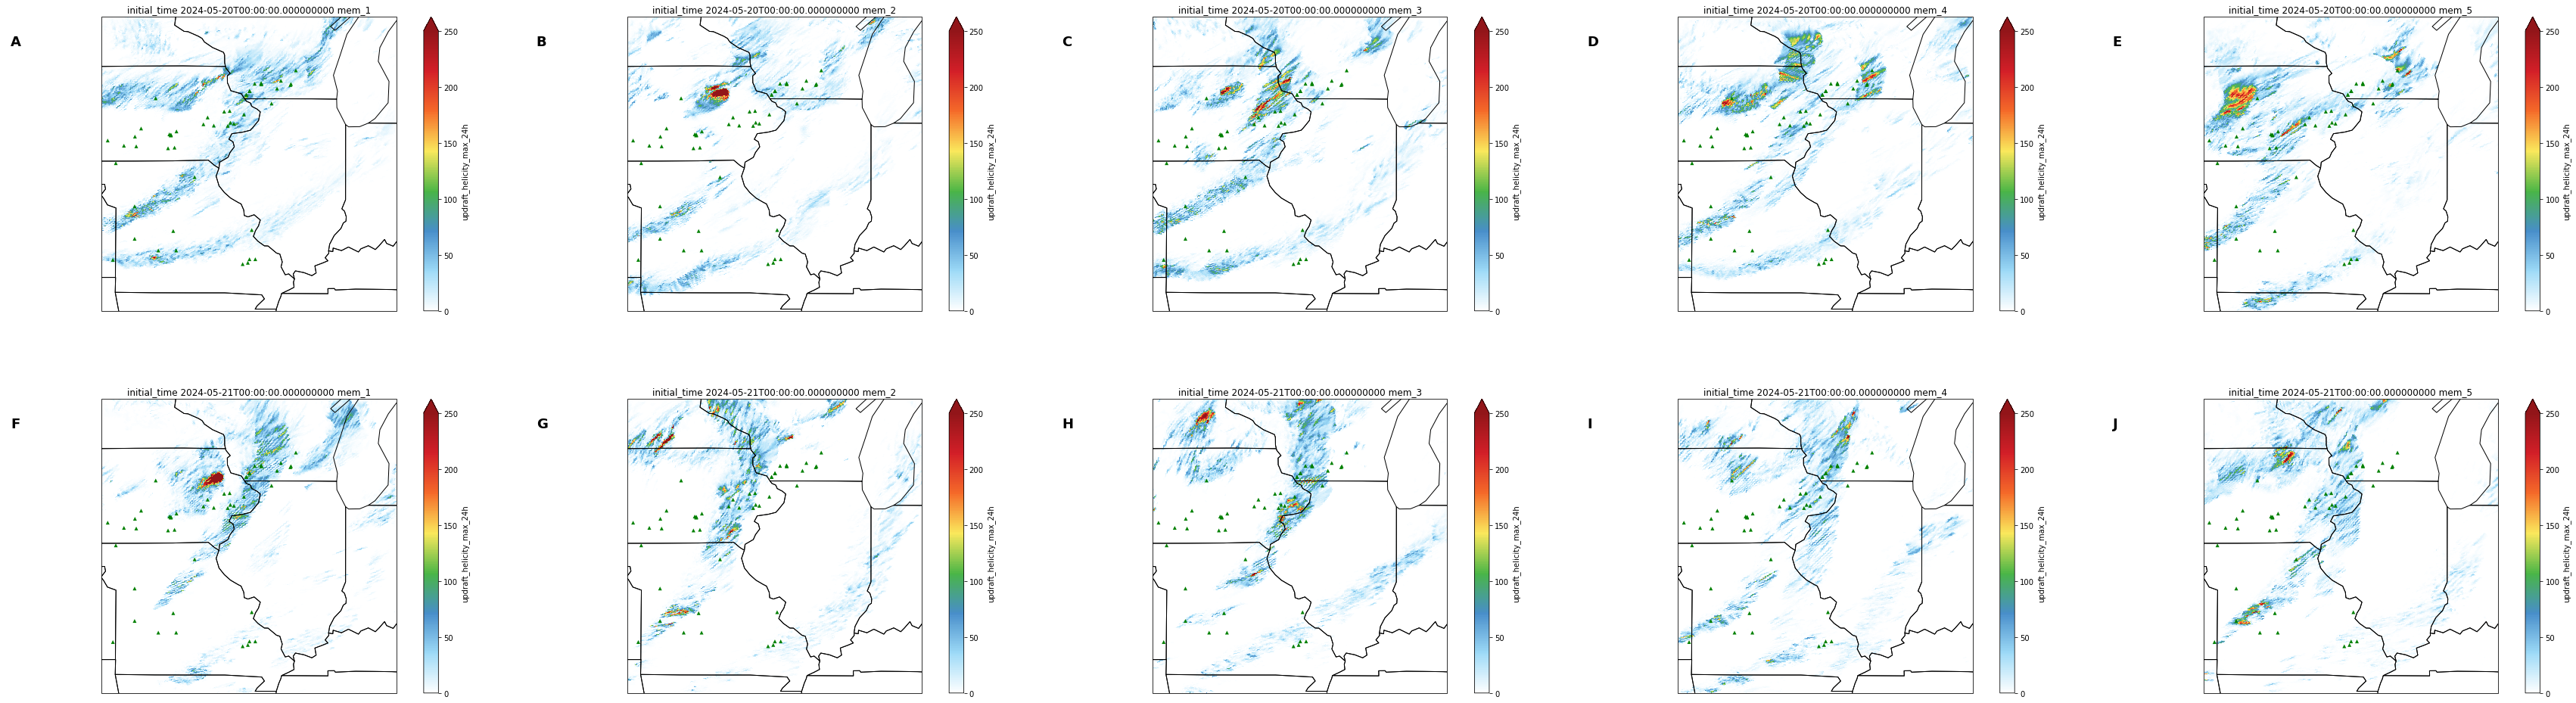

In [6]:
%%time
hv.extension("matplotlib")

# maximum value for all times
# fixed subset.bounding_box so it does not lose mem and initial_time coordinate indices.
uh_24hmax = uxds[v].subset.bounding_box(lon_bounds, lat_bounds).metpy.quantify().max(dim="valid_time")
uh_24hmax.name += "_24h"


rpt_type = "hail"
opts = {}
opts["torn"] = dict(color="red", marker="v")
opts["hail"] = dict(color="green", marker="^")
opts["wind"] = dict(color="blue", marker="s")
rpts = pd.read_csv(
    f"https://www.spc.noaa.gov/climo/reports/{valid_date.strftime('%y%m%d')}_rpts_{rpt_type}.csv"
)

# Time is an integer with hours in the thousands and hundreds place and minutes
# in the tens and ones places.
# Extract hours from time by dividing by 100 and converting result to integer.
rpts["h"] = (rpts.Time / 100).astype(int)
# Time window of spc reports is from 12 UTC on the current day to 12 UTC the next day.
# If hours is less than 12, it is from the next day. Therefore, add 24.
rpts.loc[rpts["h"] < 12, "h"] += 24
rpts["minutes"] = rpts.Time % 100
rpts["valid_time"] = (
    valid_date
    + pd.to_timedelta(rpts["h"], unit="h")
    + pd.to_timedelta(rpts["minutes"], unit="minute")
)
irange = rpts.Lat.between(*lat_bounds) & rpts.Lon.between(*lon_bounds)
logging.warning(f"{len(rpts)} {rpt_type} rpts to {irange.sum()}")
rpts = rpts[irange]


scatter = hv.Scatter(rpts[["Lon", "Lat"]]).opts(s=25, edgecolor="none", **opts[rpt_type])

title = valid_date
p_list = [
    uh_24hmax.sel(mem=mem).sel(initial_time=initial_time)
    .plot.rasterize(
        method="polygon",
        exclude_antimeridian=True,
        title=f"initial_time {initial_time} mem_{mem}",
        cmap=cmap,
        clim=(0, 250),
        backend="matplotlib",
    )
    .opts(fig_size=250)
    * features
    * scatter
    for initial_time in uh_24hmax.initial_time.data
    for mem in uh_24hmax.mem.data
]
layout = hv.Layout(p_list).cols(model.nmem)
layout.opts(fig_size=250)

CPU times: user 10.9 s, sys: 1.29 s, total: 12.2 s
Wall time: 14.8 s


:Layout
   .Overlay.I    :Overlay
      .Image.I     :Image   [x,y]   (x_y updraft_helicity_max_24h)
      .Coastline.I :Feature   [Longitude,Latitude]
      .States.I    :Feature   [Longitude,Latitude]
      .Scatter.I   :Scatter   [Lon]   (Lat)
   .Overlay.II   :Overlay
      .Image.I     :Image   [x,y]   (x_y updraft_helicity_max_24h)
      .Coastline.I :Feature   [Longitude,Latitude]
      .States.I    :Feature   [Longitude,Latitude]
      .Scatter.I   :Scatter   [Lon]   (Lat)
   .Overlay.III  :Overlay
      .Image.I     :Image   [x,y]   (x_y updraft_helicity_max_24h)
      .Coastline.I :Feature   [Longitude,Latitude]
      .States.I    :Feature   [Longitude,Latitude]
      .Scatter.I   :Scatter   [Lon]   (Lat)
   .Overlay.IV   :Overlay
      .Image.I     :Image   [x,y]   (x_y updraft_helicity_max_24h)
      .Coastline.I :Feature   [Longitude,Latitude]
      .States.I    :Feature   [Longitude,Latitude]
      .Scatter.I   :Scatter   [Lon]   (Lat)
   .Overlay.V    :Overlay
      .Image.I     :Image   [x,y]   (x_y updraft_helicity_max_24h)
      .Coastline.I :Feature   [Longitude,Latitude]
      .States.I    :Feature   [Longitude,Latitude]
      .Scatter.I   :Scatter   [Lon]   (Lat)
   .Overlay.VI   :Overlay
      .Image.I     :Image   [x,y]   (x_y updraft_helicity_max_24h)
      .Coastline.I :Feature   [Longitude,Latitude]
      .States.I    :Feature   [Longitude,Latitude]
      .Scatter.I   :Scatter   [Lon]   (Lat)
   .Overlay.VII  :Overlay
      .Image.I     :Image   [x,y]   (x_y updraft_helicity_max_24h)
      .Coastline.I :Feature   [Longitude,Latitude]
      .States.I    :Feature   [Longitude,Latitude]
      .Scatter.I   :Scatter   [Lon]   (Lat)
   .Overlay.VIII :Overlay
      .Image.I     :Image   [x,y]   (x_y updraft_helicity_max_24h)
      .Coastline.I :Feature   [Longitude,Latitude]
      .States.I    :Feature   [Longitude,Latitude]
      .Scatter.I   :Scatter   [Lon]   (Lat)
   .Overlay.IX   :Overlay
      .Image.I     :Image   [x,y]   (x_y updraft_helicity_max_24h)
      .Coastline.I :Feature   [Longitude,Latitude]
      .States.I    :Feature   [Longitude,Latitude]
      .Scatter.I   :Scatter   [Lon]   (Lat)
   .Overlay.X    :Overlay
      .Image.I     :Image   [x,y]   (x_y updraft_helicity_max_24h)
      .Coastline.I :Feature   [Longitude,Latitude]
      .States.I    :Feature   [Longitude,Latitude]
      .Scatter.I   :Scatter   [Lon]   (Lat)
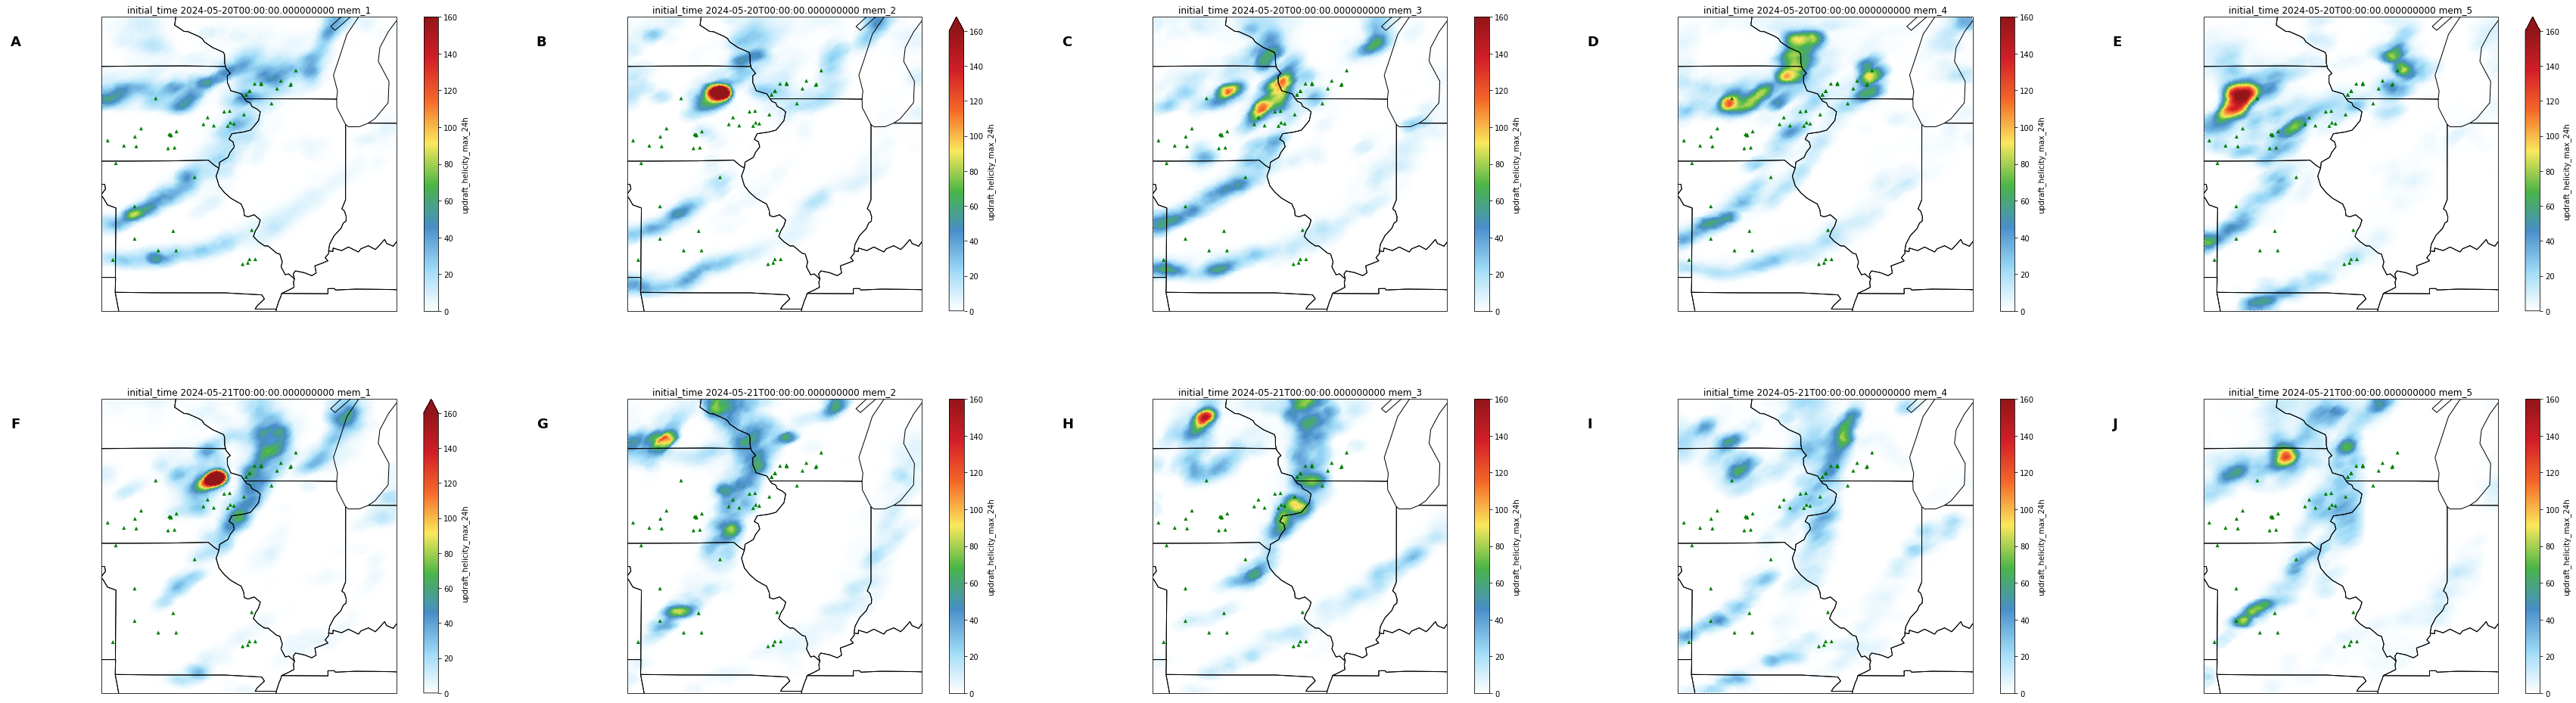

In [7]:
%%time
da = uh_24hmax.remap.inverse_distance_weighted(
    uh_24hmax.uxgrid,
    remap_to="face centers",
    power=0,
    k=169,
)
p_list = [
    da.sel(mem=mem)
    .sel(initial_time=initial_time)
    .plot.rasterize(
        method="polygon",
        exclude_antimeridian=True,
        title=f"initial_time {initial_time} mem_{mem}",
        cmap=cmap,
        clim=(0, 160),
        backend="matplotlib",
    )
    .opts(fig_size=250)
    * features
    * scatter
    for initial_time in uh_24hmax.initial_time.data
    for mem in uh_24hmax.mem.data
]
layout = hv.Layout(p_list).cols(model.nmem)
layout.opts(fig_size=250)

CPU times: user 762 ms, sys: 662 ms, total: 1.42 s
Wall time: 1.36 s


:Layout
   .Overlay.I    :Overlay
      .Image.I     :Image   [x,y]   (x_y updraft_helicity_max_24h)
      .Coastline.I :Feature   [Longitude,Latitude]
      .States.I    :Feature   [Longitude,Latitude]
      .Scatter.I   :Scatter   [Lon]   (Lat)
   .Overlay.II   :Overlay
      .Image.I     :Image   [x,y]   (x_y updraft_helicity_max_24h)
      .Coastline.I :Feature   [Longitude,Latitude]
      .States.I    :Feature   [Longitude,Latitude]
      .Scatter.I   :Scatter   [Lon]   (Lat)
   .Overlay.III  :Overlay
      .Image.I     :Image   [x,y]   (x_y updraft_helicity_max_24h)
      .Coastline.I :Feature   [Longitude,Latitude]
      .States.I    :Feature   [Longitude,Latitude]
      .Scatter.I   :Scatter   [Lon]   (Lat)
   .Overlay.IV   :Overlay
      .Image.I     :Image   [x,y]   (x_y updraft_helicity_max_24h)
      .Coastline.I :Feature   [Longitude,Latitude]
      .States.I    :Feature   [Longitude,Latitude]
      .Scatter.I   :Scatter   [Lon]   (Lat)
   .Overlay.V    :Overlay
      .Image.I     :Image   [x,y]   (x_y updraft_helicity_max_24h)
      .Coastline.I :Feature   [Longitude,Latitude]
      .States.I    :Feature   [Longitude,Latitude]
      .Scatter.I   :Scatter   [Lon]   (Lat)
   .Overlay.VI   :Overlay
      .Image.I     :Image   [x,y]   (x_y updraft_helicity_max_24h)
      .Coastline.I :Feature   [Longitude,Latitude]
      .States.I    :Feature   [Longitude,Latitude]
      .Scatter.I   :Scatter   [Lon]   (Lat)
   .Overlay.VII  :Overlay
      .Image.I     :Image   [x,y]   (x_y updraft_helicity_max_24h)
      .Coastline.I :Feature   [Longitude,Latitude]
      .States.I    :Feature   [Longitude,Latitude]
      .Scatter.I   :Scatter   [Lon]   (Lat)
   .Overlay.VIII :Overlay
      .Image.I     :Image   [x,y]   (x_y updraft_helicity_max_24h)
      .Coastline.I :Feature   [Longitude,Latitude]
      .States.I    :Feature   [Longitude,Latitude]
      .Scatter.I   :Scatter   [Lon]   (Lat)
   .Overlay.IX   :Overlay
      .Image.I     :Image   [x,y]   (x_y updraft_helicity_max_24h)
      .Coastline.I :Feature   [Longitude,Latitude]
      .States.I    :Feature   [Longitude,Latitude]
      .Scatter.I   :Scatter   [Lon]   (Lat)
   .Overlay.X    :Overlay
      .Image.I     :Image   [x,y]   (x_y updraft_helicity_max_24h)
      .Coastline.I :Feature   [Longitude,Latitude]
      .States.I    :Feature   [Longitude,Latitude]
      .Scatter.I   :Scatter   [Lon]   (Lat)
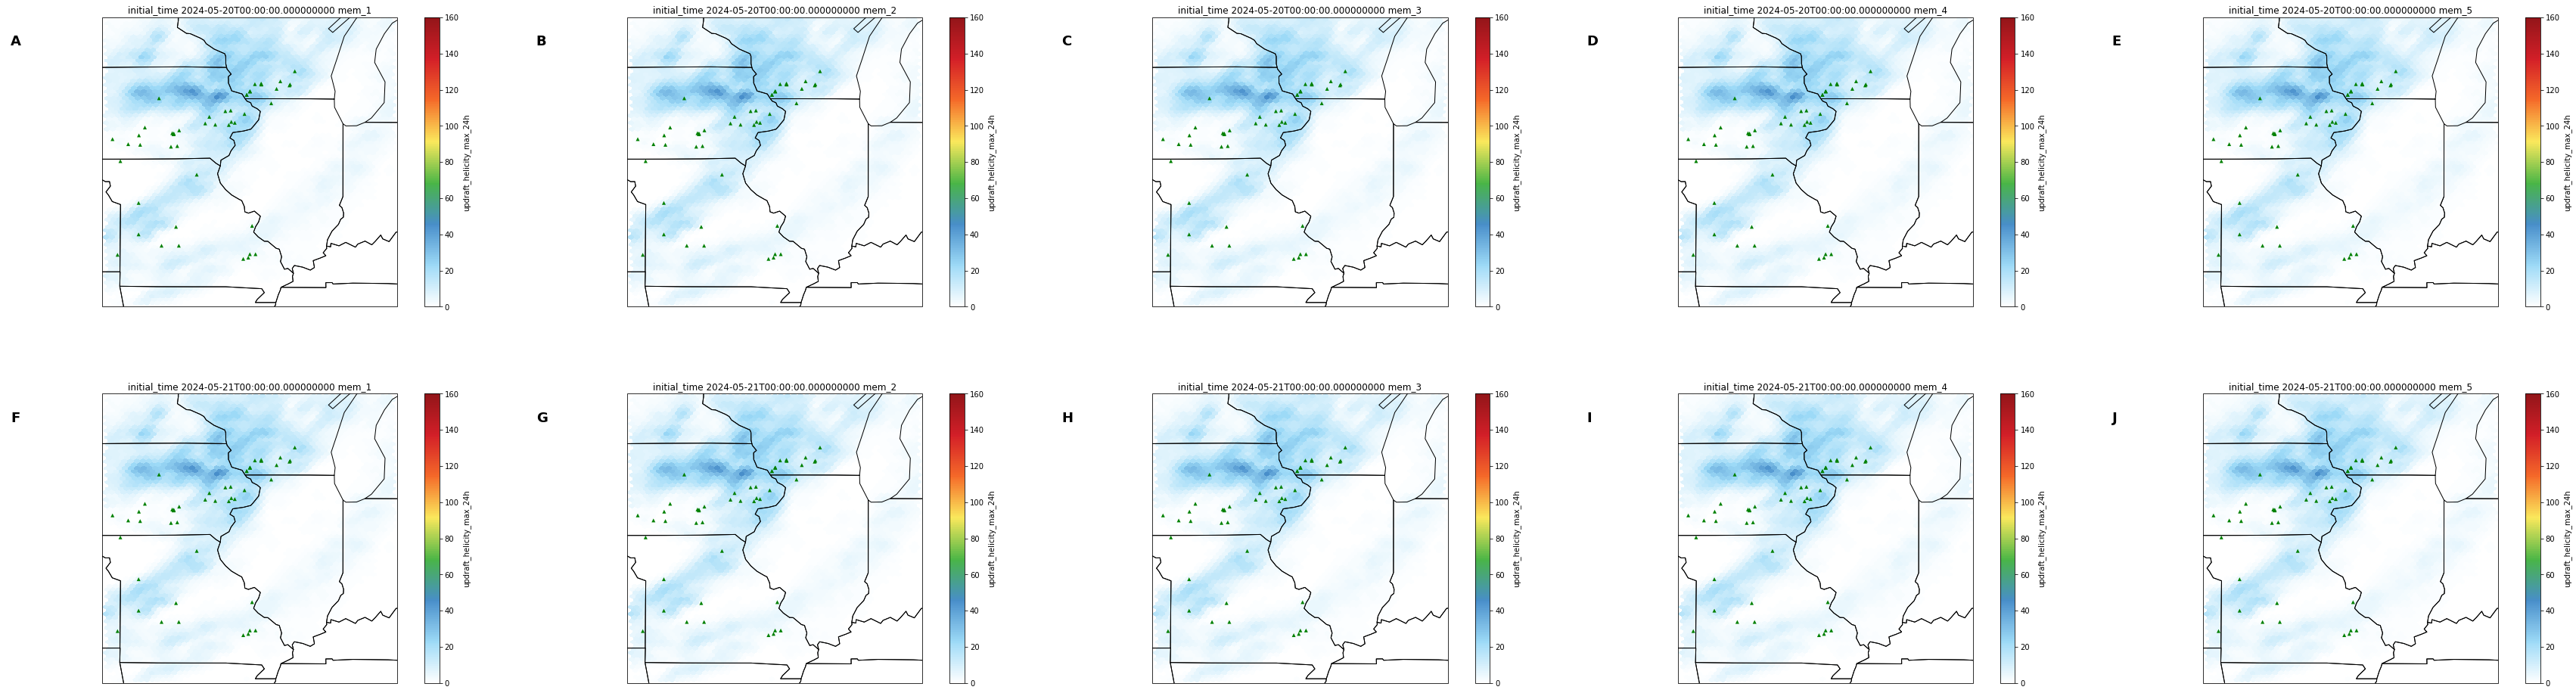

In [12]:
%%time
coarse_mesh_path = Path(
    "/glade/campaign/mmm/parc/schwartz/MPAS_regional/15km_mesh_regional/mpas_init/regional_15km_mesh_2000km.static.nc"
)
coarse_mesh = uxarray.open_grid(coarse_mesh_path).subset.bounding_box(lon_bounds, lat_bounds)

da = uh_24hmax.remap.inverse_distance_weighted(coarse_mesh).neighborhood_filter(r=20./111., func=np.mean)
p_list = [
    da.sel(mem=mem)
    .sel(initial_time=initial_time)
    .plot.rasterize(
        method="polygon",
        exclude_antimeridian=True,
        title=f"initial_time {initial_time} mem_{mem}",
        cmap=cmap,
        clim=(0, 160),
        backend="matplotlib",
    )
    .opts(fig_size=250)
    * features
    * scatter
    for initial_time in uh_24hmax.initial_time.data
    for mem in uh_24hmax.mem.data
]
layout = hv.Layout(p_list).cols(model.nmem)
layout.opts(fig_size=250)

:Layout
   .Overlay.I  :Overlay
      .Image.I     :Image   [x,y]   (x_y ensemble probability of 40+ updraft_helicity_max_24h within 20.0 km)
      .Coastline.I :Feature   [Longitude,Latitude]
      .States.I    :Feature   [Longitude,Latitude]
      .Scatter.I   :Scatter   [Lon]   (Lat)
   .Overlay.II :Overlay
      .Image.I     :Image   [x,y]   (x_y ensemble probability of 40+ updraft_helicity_max_24h within 20.0 km)
      .Coastline.I :Feature   [Longitude,Latitude]
      .States.I    :Feature   [Longitude,Latitude]
      .Scatter.I   :Scatter   [Lon]   (Lat)
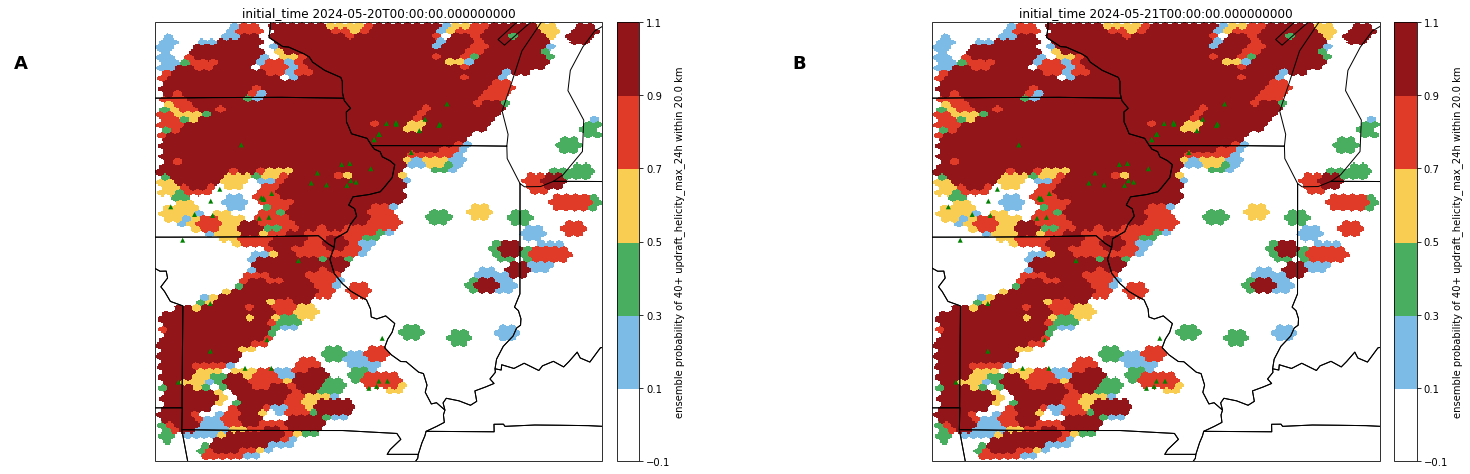

In [13]:
uh_thresh = helicityThresholds.metpy.quantify()[3]

r = 20.
fy = (uh_24hmax >= uh_thresh).remap.inverse_distance_weighted(coarse_mesh).neighborhood_filter(r=r/111., func=np.max)

fy = fy.mean(dim="mem")
fy.name = f"ensemble probability of {uh_thresh.values}+ {uh_24hmax.name} within {r} km"

values = fy.values
values[values > 1] = 1
fy.values = values
assert fy.max() <= 1
p_list = [
    fy.sel(initial_time=initial_time)
    .plot.rasterize(
        method="polygon",
        exclude_antimeridian=True,
        title=f"initial_time {initial_time}",
        cmap=cmap,
        norm = matplotlib.colors.BoundaryNorm(boundaries=np.arange(-0.5/model.nmem,1+0.5/model.nmem,1/model.nmem),ncolors=256),
        backend="matplotlib",
    )
    .opts(fig_size=250)
    * features
    * scatter
    for initial_time in fy.initial_time.data
]
layout = hv.Layout(p_list).cols(fy.initial_time.size)
layout.opts(fig_size=250)

In [14]:
verify_fine_mesh = False
if verify_fine_mesh:
    prob_thresh = 0.4
    fy = uxarray.UxDataArray((fy >= prob_thresh).astype(int), uxgrid=coarse_mesh)
    fy.name = f"ensemble probability of {uh_thresh}+ {uh_24hmax.name} >= {prob_thresh}"
    fy = fy.remap.nearest_neighbor(uh_24hmax.uxgrid)
    fy = uxarray.UxDataArray(fy, uxgrid=uh_24hmax.uxgrid)

    p_list = [
        fy.sel(initial_time=initial_time)
        .plot.rasterize(
            method="polygon",
            exclude_antimeridian=True,
            backend="matplotlib",
        )
        * features
        for initial_time in fy.initial_time.data
    ]
    layout = hv.Layout(p_list).cols(fy.initial_time.size)
    layout.opts(fig_size=250)

In [15]:
fy

<xarray.UxDataArray 'ensemble probability of 40+ updraft_helicity_max_24h within 20.0 km' (
                                                                                           initial_time: 2,
                                                                                           n_face: 4059)> Size: 65kB
array([[0.03439013, 0.        , 0.9911984 , ..., 0.        , 0.        ,
        0.        ],
       [0.03439013, 0.        , 0.9911984 , ..., 0.        , 0.        ,
        0.        ]])
Coordinates:
  * initial_time  (initial_time) datetime64[ns] 16B 2024-05-20 2024-05-21
Dimensions without coordinates: n_face

In [16]:
# reduce initialization time dimension.
# could be max. could be mean..
fy = fy.mean(dim="initial_time")


uxtree = coarse_mesh.get_ball_tree(coordinates="face centers")
rptdist = 40  # km
# get indices close to report (for each report)
idx = uxtree.query_radius(rpts[["Lon", "Lat"]], rptdist / 111.0)


oy = fy.copy()
# initialize with False
oy.values[:] = False
oy.name = rpt_type
for i in idx:
    oy.values.put(i, True)

:Overlay
   .Image.I     :Image   [x,y]   (x_y hail)
   .Scatter.I   :Scatter   [Lon]   (Lat)
   .Coastline.I :Feature   [Longitude,Latitude]
   .States.I    :Feature   [Longitude,Latitude]
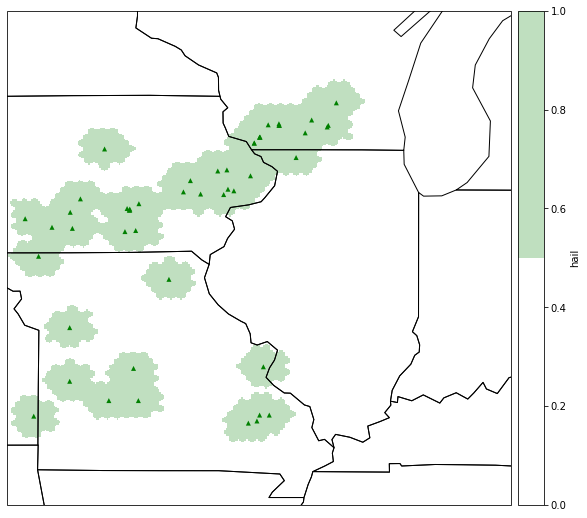

In [17]:
oy.plot.rasterize(
    method="polygon",
    exclude_antimeridian=True,
    cmap=["white", opts[rpt_type]["color"]],
    alpha=0.25,
    backend="matplotlib",
).opts(fig_size=250) * scatter * features

:Overlay
   .Image.I     :Image   [x,y]   (x_y hit/miss/fa/null)
   .Coastline.I :Feature   [Longitude,Latitude]
   .States.I    :Feature   [Longitude,Latitude]
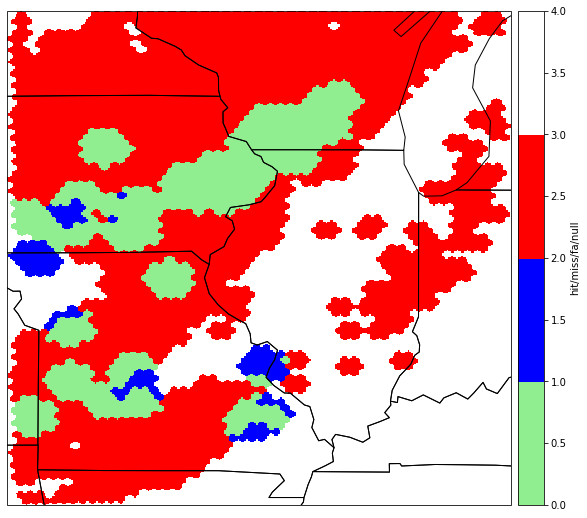

In [18]:
prob_thresh = 1e-9
on = 1 - oy
hit = oy * (fy >= prob_thresh)
miss = oy * (fy < prob_thresh)
correct_null = on * (fy < prob_thresh)
fa = on * (fy >= prob_thresh)
hmfn = hit * 0 + miss * 1 + fa * 2 + correct_null * 3
hmfn.name = "hit/miss/fa/null"

hmfn.plot.rasterize(
    method="polygon",
    exclude_antimeridian=True,
#    title=title,
    cmap=["lightgreen", "blue", "red", "white"],
    clim=(0, 4),
    backend="matplotlib",
).opts(fig_size=250) * features

-1.702


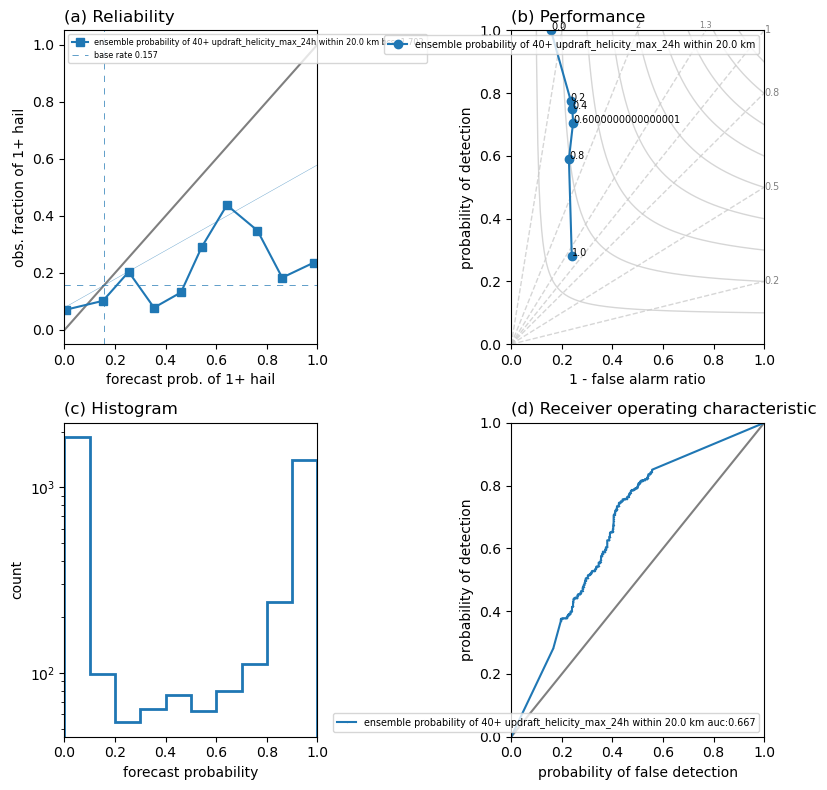

In [21]:
import statisticplot

%matplotlib inline
plt.close("all")
fig = statisticplot.stat_plots(oy, fy, thresh=[1], o_thresh_roc=1)

In [22]:
probability_of_detection = hit.sum() / (hit.sum() + miss.sum())
probability_of_detection

false_alarm_ratio = fa.sum() / (hit.sum() + fa.sum())
false_alarm_ratio
# Pandas DataFrame filled with zeros
# indexed (rows) by thresholds
# columns are hits, misses, fa, and null
contingency_table = pd.DataFrame(
    0, index=helicityThresholds, columns=["hits", "misses", "false alarms", "correct nulls"]
)
contingency_table
contingency_table = pd.DataFrame(index=["yes", "no"], columns=["yes", "no"])
contingency_table.index.name = "forecast"
contingency_table.columns.name = "observed"
contingency_table.loc["yes", "yes"] = f"{hit.sum().values:.0f} hits"
contingency_table.loc["no", "yes"] = f"{miss.sum().values:.0f} miss"
contingency_table.loc["yes", "no"] = f"{fa.sum().values:.0f} falarm"
contingency_table.loc["no", "no"] = f"{correct_null.sum().values:.0f} null"
contingency_table

observed       yes           no
forecast                       
yes       541 hits  1906 falarm
no         95 miss    1517 null

In [23]:
from statisticplot import make_map

pc = hmfn.to_polycollection(projection=projection, override=True)
pc.set_antialiased(False)
pc.set_cmap("plasma")

# add geographic features
fig, ax = make_map()

ax.add_collection(pc)

lon0 = -98
lon1 = -88
lat0 = 35
lat1 = 42
ax.set_extent((lon0, lon1, lat0, lat1))


NameError: name 'projection' is not defined